# BERT & The Encoders

## Understanding Bidirectional Models

In the previous notebooks, we explored **Decoders** (like GPT), which generate text one word at a time, looking only at the past. 

Now, we look at the **Encoder** (like BERT). 

### What is the difference?
- **Decoder (GPT)**: "I went to the store to buy _____." -> Predicts "milk". (Looks Left-to-Right).
- **Encoder (BERT)**: "I went to the [MASK] to buy milk." -> Predicts "store". (Looks **Bidirectionally**, at both left and right context).

Encoders are excellent at **understanding**, **classification**, and **filling in the blanks**.

### What We Will Build
We will build a "Mini-BERT" from scratch that plays the **Cloze Game** (Masked Language Modeling). We will teach it simple facts, and then ask it to fill in missing information.

**Concepts:**
1. **Special Tokens**: `[CLS]`, `[SEP]`, `[MASK]`.
2. **Bidirectional Attention**: No causal masking! Everyone looks at everyone.
3. **Masked Language Modeling (MLM)**: The training technique behind BERT.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import re
import random

# Set seed
torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. The Data: Factoids

Encoders are great at learning relationships. Let's create a dataset of simple "General Knowledge" facts. We want the model to learn that "Paris" goes with "France" and "Apple" goes with "Red".

In [8]:
raw_text = """
paris is the capital of france
berlin is the capital of germany
rome is the capital of italy
madrid is the capital of spain
london is the capital of england
the sky is blue during the day
the grass is green in the summer
apples are red and delicious
bananas are yellow and sweet
dogs are loyal pets
cats are independent pets
fish swim in the water
birds fly in the sky
"""

# 1. Simple Tokenizer
def tokenizer(text):
    return re.findall(r"\w+|\[mask\]", text.lower())

tokens = tokenizer(raw_text)
vocab = sorted(list(set(tokens)))

# 2. Add Special BERT Tokens
# [PAD]: Padding used to make sequences same length
# [MASK]: The token we want the model to predict
# [UNK]: Unknown words
special_tokens = ['[PAD]', '[MASK]', '[UNK]']
vocab = special_tokens + vocab

word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for i,w in enumerate(vocab)}

vocab_size = len(vocab)
print(f"Vocab Size: {vocab_size}")
print(f"Vocab: {vocab}")

Vocab Size: 43
Vocab: ['[PAD]', '[MASK]', '[UNK]', 'and', 'apples', 'are', 'bananas', 'berlin', 'birds', 'blue', 'capital', 'cats', 'day', 'delicious', 'dogs', 'during', 'england', 'fish', 'fly', 'france', 'germany', 'grass', 'green', 'in', 'independent', 'is', 'italy', 'london', 'loyal', 'madrid', 'of', 'paris', 'pets', 'red', 'rome', 'sky', 'spain', 'summer', 'sweet', 'swim', 'the', 'water', 'yellow']


## 2. Masking: The Training Game

In BERT training, we take a sentence and randomly replace a word with `[MASK]`.
- **Input**: `paris is the [MASK] of france`
- **Target Label**: `capital`

The model must use the context ("Paris", "France") to figure out the missing word.

In [9]:
sentences = raw_text.strip().split('\n')

def create_masked_input(sentence_str):
    # Convert to ID list
    words = tokenizer(sentence_str)
    input_ids = [word2idx[w] for w in words]
    
    # Select a random position to mask (not the whole sentence, just one word for this demo)
    # In real BERT, they mask 15% of tokens
    mask_pos = random.randint(0, len(input_ids) - 1)
    target_word_id = input_ids[mask_pos]
    
    # Replace with [MASK] token ID
    input_ids[mask_pos] = word2idx['[MASK]']
    
    return torch.tensor(input_ids), torch.tensor(target_word_id), mask_pos

# Test it
inp, tgt, pos = create_masked_input("paris is the capital of france")
print(f"Original: paris is the capital of france")
print(f"Masked Input: {[idx2word[i.item()] for i in inp]}")
print(f"Target ID: {tgt.item()} ({idx2word[tgt.item()]})")

Original: paris is the capital of france
Masked Input: ['paris', 'is', 'the', 'capital', 'of', '[MASK]']
Target ID: 19 (france)


## 3. The Encoder Architecture

We use `nn.TransformerEncoder`. 

**Crucial Difference from Decoder:** 
Notice we do **NOT** generate a causal mask. We want the attention mechanism to see the whole sequence. If we mask the future, the model can't see "France" to help predict "capital" in the example above.

In [10]:
class MiniBERT(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers):
        super().__init__()
        
        # 1. Embeddings
        self.embedding = nn.Embedding(vocab_size, d_model)
        # Simple learned positional encoding
        self.pos_embedding = nn.Embedding(100, d_model) 
        
        # 2. Transformer Encoder
        # Note: No "Mask" parameter is needed for the Attention here.
        # It is bidirectional by default.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=d_model*4,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 3. Output Head (Predict word from vocab)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        # x shape: [Batch, SeqLen]
        B, T = x.shape
        
        # Create positions [0, 1, 2...]
        positions = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)
        
        # Combine Embeddings
        x = self.embedding(x) + self.pos_embedding(positions)
        
        # Pass through Encoder
        # NO CAUSAL MASK passed here! 
        # Padding mask can be passed if we had variable lengths, but we will keep it simple.
        x = self.transformer_encoder(x)
        
        # Predict words
        logits = self.fc(x)
        
        return logits

## 4. Training Loop

We train by creating batches where every sentence has exactly one random word masked. The model tries to reduce the Cross Entropy Loss between its prediction at the masked position and the real word.

In [11]:
# Hyperparameters
d_model = 64
nhead = 4
num_layers = 2

model = MiniBERT(vocab_size, d_model, nhead, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

EPOCHS = 500

print("Training MiniBERT...")
for epoch in range(EPOCHS):
    total_loss = 0
    
    # Shuffle sentences for variety
    random.shuffle(sentences)
    
    for sent in sentences:
        # Create data for this sentence
        inputs, target_id, mask_pos = create_masked_input(sent)
        
        # Move to device and add batch dimension
        inputs = inputs.unsqueeze(0).to(device)      # [1, SeqLen]
        target_id = target_id.unsqueeze(0).to(device) # [1]
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(inputs) # [1, SeqLen, VocabSize]
        
        # Extract the prediction specifically at the [MASK] position
        # We only care if it gets the masked word right.
        mask_logits = logits[0, mask_pos, :].unsqueeze(0) # [1, VocabSize]
        
        loss = criterion(mask_logits, target_id)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1} | Loss: {total_loss/len(sentences):.4f}")

Training MiniBERT...
Epoch 50 | Loss: 0.4794
Epoch 100 | Loss: 0.0416
Epoch 150 | Loss: 0.0169
Epoch 200 | Loss: 0.0054
Epoch 250 | Loss: 0.0318
Epoch 300 | Loss: 0.0230
Epoch 350 | Loss: 0.0353
Epoch 400 | Loss: 0.0029
Epoch 450 | Loss: 0.0023
Epoch 500 | Loss: 0.0023


## 5. Playing the "Fill in the Blank" Game

Now that BERT is trained, let's test it. We will provide sentences with a `[MASK]` token and see if it can fill it based on the bidirectional context.

In [12]:
def predict_mask(sentence_str):
    model.eval()
    
    # 1. Tokenize (using the improved logic to keep brackets)
    words = tokenizer(sentence_str)
    
    # 2. Find mask position
    try:
        mask_pos = words.index('[mask]')
    except ValueError:
        return "Error: You must include '[mask]' in your sentence!"
    
    # 3. Convert to IDs
    # Handle the special case where '[mask]' (input) needs to map to '[MASK]' (vocab ID)
    input_ids = []
    for w in words:
        if w == '[mask]':
            input_ids.append(word2idx['[MASK]'])
        else:
            input_ids.append(word2idx.get(w, word2idx['[UNK]']))
            
    input_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)
    
    # 4. Predict
    with torch.no_grad():
        logits = model(input_tensor)
        
        # Look at the [MASK] position
        masked_token_logits = logits[0, mask_pos, :]
        
        # Get top prediction
        pred_id = torch.argmax(masked_token_logits).item()
        pred_word = idx2word[pred_id]
        
    # 5. Visual Output
    words[mask_pos] = f"__{pred_word.upper()}__"
    return " ".join(words)

# Test Cases
print(predict_mask("paris is the [mask] of france"))
print(predict_mask("apples are [mask] and delicious"))

paris is the __CAPITAL__ of france
apples are __RED__ and delicious


## 6. Visualizing Attention (The "Understanding")

Let's visualize how the model connects words. In a Decoder (GPT), attention only goes to the left. In an Encoder (BERT), attention lines should go **both ways**.

When solving "Paris is the [MASK] of France", the `[MASK]` token should strongly attend to both "Paris" (start of sentence) and "France" (end of sentence).

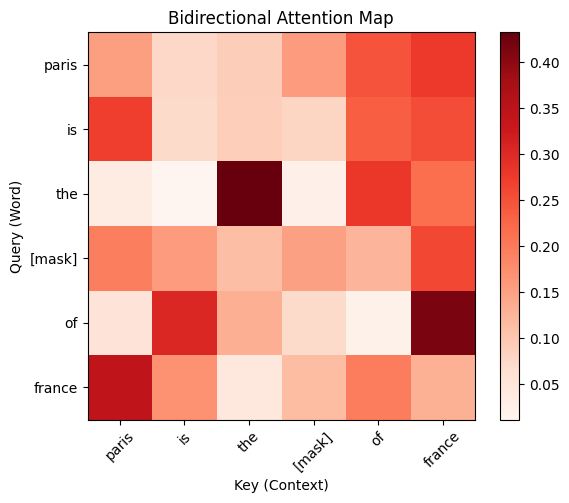

In [13]:
import matplotlib.pyplot as plt

def show_attention(sentence_str):
    model.eval()
    words = tokenizer(sentence_str)
    input_ids = [word2idx.get(w, word2idx['[UNK]']) for w in words]
    input_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)
    
    # Hook into the model to extract attention weights from the last layer
    # PyTorch's TransformerEncoder doesn't output weights easily by default,
    # so we'll simulate a manual pass of the Self-Attention layer for visualization.
    
    with torch.no_grad():
        # Get embeddings
        x = model.embedding(input_tensor)
        
        # Run standard Multihead Attention manually to get weights
        # This mimics what happens inside the encoder layer
        attn_layer = model.transformer_encoder.layers[0].self_attn
        _, weights = attn_layer(x, x, x)
        
        # Take first head [Batch, Head, Seq, Seq] -> [Seq, Seq]
        w = weights[0].cpu().numpy()
        
    plt.figure(figsize=(6,5))
    plt.imshow(w, cmap='Reds')
    plt.xticks(range(len(words)), words, rotation=45)
    plt.yticks(range(len(words)), words)
    plt.title("Bidirectional Attention Map")
    plt.xlabel("Key (Context)")
    plt.ylabel("Query (Word)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

show_attention("paris is the [mask] of france")

## Conclusion

You have built an **Encoder (BERT)** model!

### Key Differences Summary:
| Feature | Decoder (GPT) | Encoder (BERT) |
|---------|---------------|----------------|
| **Direction** | Left-to-Right (Causal) | Bidirectional (Full) |
| **Task** | Next Token Prediction | Masked Language Modeling |
| **Strength** | Generating Stories | Understanding / Classification |
| **Masking** | Causal Mask (Triangle) | No Mask (Full Attention) |

**Next Steps:**
- Try adding a CLS token to do Sentence Classification (e.g., is this sentence about Geography or Animals?).
- Increase the dataset size to include more complex facts.